Notebook written in preparation for the 16 Sept UBC meeting

In [1]:
from typing import Optional, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from analytical_models.gde_co import InputParameters, System, solve, solve_current

Spreadsheet indicates 800mA. Their cathode is approximately 4cm^2 (Felix's estimate), so current density about 200mA/cm^2

Calculate approximate catalyst layer thickness. 
Use catalyst mass loading in mg, approximate surface area 4cm^2

Abhishek: porosity 0.8, particle size ~25-50nm, gas permeability ~8.7e-8 m^2

CO2 pressure 20 psi = 1.38 bar (assuming 20psi above atmospheric)

In [2]:
dens_Ag = 10490 # kg/m^3
mass = 15.4e-6 # kg
area = 4e-4 # m^2
porosity = 0.8
thickness = (mass / dens_Ag / (1-porosity))/area # m
print(thickness)

T = 298.15 # K
p = 2.38 # bar

args = dict(
    T=T, 
    p0=p, 
    Q=30, # liquid flow rate , ml/min 
    flow_chan_length=0.02, 
    flow_chan_height=5e-3, 
    flow_chan_width=1.5e-3, 
    L=thickness, 
    # L=3.81E-06, 
    eps=porosity, # porosity 0.8
    r=(25+50)/2 * 1e-9, # 25 - 50 nm 
    c_khco3=500, 
    c_k=500, 
    dic=10**-3.408, 
    method='CO2 eql'
)

1.8350810295519547e-05


GDL mass transfer coefficient can affect the Faradaic efficiency significantly

In [3]:
ipt = InputParameters(**args)
ipt.L *= 1.3
S = System(ipt)
S.diffusion_coefficients['Gas diffusion layer mass transfer coefficient'] /= 10
S.diffusion_coefficients['Gas diffusion layer mass transfer coefficient']

0.003644492660927657

In [4]:
# Data:
V = -1*np.array([2.130e+00, 2.220e+00, 2.620e+00, 2.200e+00, 2.160e+00, 2.620e+00,
        2.210e+00, 2.400e+00, 2.470e+00, 2.130e+00, 2.370e+00, 2.390e+00,
        2.190e+00, 2.100e+00, 2.530e+00, 2.090e+00, 2.210e+00])
FE = 0.01*np.array([3.589e+01, 4.429e+01, 5.516e+01, 4.251e+01, 4.427e+01, 4.804e+01,
        3.740e+01, 3.831e+01, 3.898e+01, 4.825e+01, 4.061e+01, 5.451e+01,
        3.819e+01, 4.306e+01, 5.842e+01, 4.584e+01, 3.849e+01])
i = 200

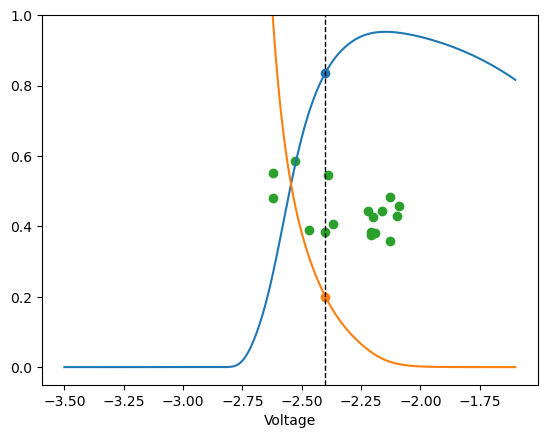

In [5]:
op = solve_current(S, i)
results = solve(S, np.linspace(-1.9,0,500))
results['phi_ext'] -= 1.6
op['phi_ext'] -= 1.6
plt.plot(results['phi_ext'], results['fe'], label='FE CO')
plt.plot(results['phi_ext'], results['current_density']/1000, c='C1', label='Current density (A/cm^2)')
plt.scatter(op['phi_ext'], op['fe'], c='C0')
plt.scatter(op['phi_ext'], op['current_density']/1000, c='C1')

plt.scatter(V, FE, c='C2', label='Data')

plt.axvline(x=op['phi_ext'], c='k', ls='--', lw=1)
plt.ylim(-0.05,1)
# plt.legend()
plt.xlabel('Voltage');

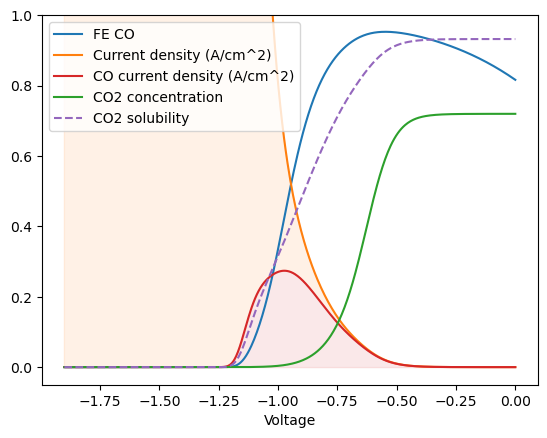

In [6]:
results = solve(S, np.linspace(-1.9,0,500))

plt.plot(results['phi_ext'], results['fe'], label='FE CO')
plt.plot(results['phi_ext'], results['current_density']/1000, c='C1', label='Current density (A/cm^2)')
plt.plot(results['phi_ext'], results['co_current_density']/1000, c='C3', label='CO current density (A/cm^2)')
plt.fill_between(results['phi_ext'], y1=results['co_current_density']/1000, y2=results['current_density']/1000, alpha=0.1, color='C1')
plt.fill_between(results['phi_ext'], results['co_current_density']/1000, alpha=0.1, color='C3')
plt.plot(results['phi_ext'], results['co2']/100, c='C2', label='CO2 concentration')
plt.plot(results['phi_ext'], results['solubility'], c='C4', label='CO2 solubility', ls='--')
plt.ylim(-0.05,1)
plt.legend()
plt.xlabel('Voltage');

# Sensitivity to parameters

In [7]:
base_args = dict(
    T=298.15, 
    p0=2.38, 
    Q=30, # liquid flow rate , ml/min 
    flow_chan_length=0.02, 
    flow_chan_height=5e-3, 
    flow_chan_width=1.5e-3, 
    L=1.835e-5, 
    eps=0.8, # porosity 0.8
    r=(25+50)/2 * 1e-9, # 25 - 50 nm 
    c_khco3=500, 
    c_k=500, 
    dic=10**-3.408, 
    method='CO2 eql'
)

In [8]:
def calc_variation(base_args, d_ipt: Optional[str] = None, d_S: Optional[Tuple[str, str]] = None):
    minus = 0.9
    plus = 1.1
    # base calculation
    ipt = InputParameters(**base_args)
    S = System(ipt)
    op = solve_current(S, 200)
    base_fe = op['fe']
    # -5% calculation
    args = base_args.copy()
    if d_ipt:
        x0 = args[d_ipt]
        x_minus = x0 * minus
        args[d_ipt] = x_minus
    ipt = InputParameters(**args)
    S = System(ipt)
    if d_S:
        assert hasattr(S, d_S[0])
        dct = getattr(S, d_S[0])
        x0 = dct[d_S[1]]
        x_minus = x0 * minus
        dct[d_S[1]] = x_minus
        setattr(S, d_S[0], dct)
    op = solve_current(S, 200)
    fe_minus = op['fe']
    # +5% calculation
    args = base_args.copy()
    if d_ipt:
        x0 = args[d_ipt]
        x_plus = x0 * plus
        args[d_ipt] = x_plus
    ipt = InputParameters(**args)
    S = System(ipt)
    if d_S:
        assert hasattr(S, d_S[0])
        dct = getattr(S, d_S[0])
        x0 = dct[d_S[1]]
        x_plus = x0 * plus
        dct[d_S[1]] = x_plus
        setattr(S, d_S[0], dct)
    op = solve_current(S, 200)
    fe_plus = op['fe']
    dfe_dx = (fe_plus - fe_minus) / (x_plus - x_minus)
    return dfe_dx / (base_fe / x0)

In [9]:
ipt_params_list = set(base_args.keys())
ipt_params_list.remove('method')
ipt_params_list

{'L',
 'Q',
 'T',
 'c_k',
 'c_khco3',
 'dic',
 'eps',
 'flow_chan_height',
 'flow_chan_length',
 'flow_chan_width',
 'p0',
 'r'}

In [10]:
system_param_probe = []
system_params_dicts = ['diffusion_coefficients', 'salting_out_exponents', 'electrode_reaction_kinetics', 'chemical_reaction_rates']
for spd in system_params_dicts:
    for key in getattr(S, spd).keys():
        system_param_probe.append((spd, key))
system_param_probe

[('diffusion_coefficients', 'CO2'),
 ('diffusion_coefficients', 'OH'),
 ('diffusion_coefficients', 'CO3'),
 ('diffusion_coefficients', 'HCO3'),
 ('diffusion_coefficients', 'H'),
 ('diffusion_coefficients', 'K'),
 ('diffusion_coefficients', 'CO'),
 ('diffusion_coefficients', 'H2'),
 ('diffusion_coefficients', 'DCO2'),
 ('diffusion_coefficients', 'DOH'),
 ('diffusion_coefficients', 'DCO3'),
 ('diffusion_coefficients', 'DHCO3'),
 ('diffusion_coefficients', 'DH'),
 ('diffusion_coefficients', 'DK'),
 ('diffusion_coefficients', 'DCO'),
 ('diffusion_coefficients', 'DH2'),
 ('diffusion_coefficients', 'Gas diffusion layer mass transfer coefficient'),
 ('salting_out_exponents', 'h_OH'),
 ('salting_out_exponents', 'h_CO3'),
 ('salting_out_exponents', 'h_HCO3'),
 ('salting_out_exponents', 'h_K'),
 ('salting_out_exponents', 'h_CO2'),
 ('electrode_reaction_kinetics', 'i_0_CO'),
 ('electrode_reaction_kinetics', 'i_0_H2a'),
 ('electrode_reaction_kinetics', 'i_0_H2b'),
 ('electrode_reaction_kinetics', 

In [11]:
sensitivities = {}
for ipt_param in ipt_params_list:
    try:
        sensitivities[ipt_param] = calc_variation(base_args, d_ipt=ipt_param)
    except:
        print(f'Error calculating sensitivity for {ipt_param}')
        continue

for spd, key in system_param_probe:
    try:
        sensitivities[f'{spd}.{key}'] = calc_variation(base_args, d_S=(spd, key))
    except:
        print(f'Error calculating sensitivity for {spd} - {key}')
        continue
sensitivities

Error calculating sensitivity for T
Error calculating sensitivity for c_khco3


C:\Users\ig348\AppData\Local\Temp\ipykernel_35552\4112431041.py:43: RuntimeWarning: invalid value encountered in scalar divide
  dfe_dx = (fe_plus - fe_minus) / (x_plus - x_minus)
C:\Users\ig348\AppData\Local\Temp\ipykernel_35552\4112431041.py:44: RuntimeWarning: divide by zero encountered in scalar divide
  return dfe_dx / (base_fe / x0)


{'flow_chan_width': -0.04754788164418822,
 'c_k': -2.1935116402478445e-05,
 'dic': 0.0005866423843150146,
 'p0': 0.18241956136169396,
 'eps': 0.21981456620533674,
 'r': 0.01893381679417735,
 'L': -0.1134431761696601,
 'Q': 0.02290474005002456,
 'flow_chan_height': -0.02280793930211483,
 'flow_chan_length': -0.02280793930211483,
 'diffusion_coefficients.CO2': 0.0,
 'diffusion_coefficients.OH': 0.0,
 'diffusion_coefficients.CO3': 0.0,
 'diffusion_coefficients.HCO3': 0.0,
 'diffusion_coefficients.H': 0.0,
 'diffusion_coefficients.K': 0.0,
 'diffusion_coefficients.CO': 0.0,
 'diffusion_coefficients.H2': 0.0,
 'diffusion_coefficients.DCO2': 0.0898837115132541,
 'diffusion_coefficients.DOH': 0.0,
 'diffusion_coefficients.DCO3': 0.0,
 'diffusion_coefficients.DHCO3': 0.0,
 'diffusion_coefficients.DH': 0.0,
 'diffusion_coefficients.DK': 0.0,
 'diffusion_coefficients.DCO': 0.0,
 'diffusion_coefficients.DH2': 0.0,
 'diffusion_coefficients.Gas diffusion layer mass transfer coefficient': 0.00182700

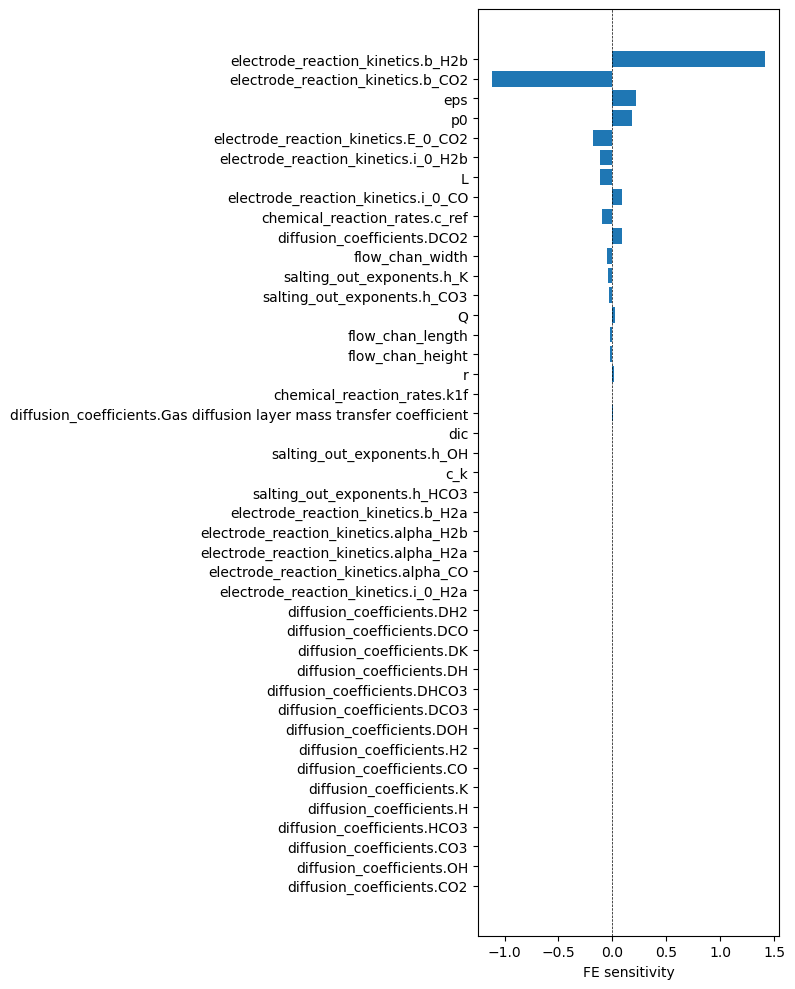

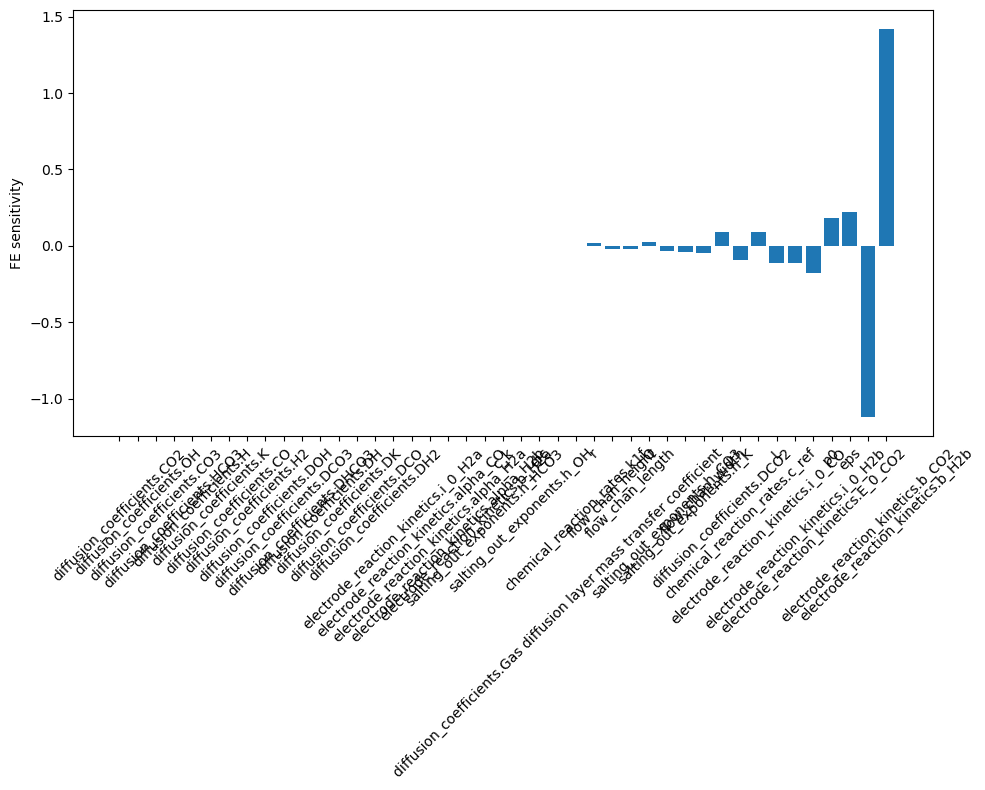

In [12]:
# drop those with nan sensitivity
sensitivities = {k: v for k, v in sensitivities.items() if not np.isnan(v)}
# bar chart sorted by sensitivity. bars horizontal
sorted_sensitivities = dict(sorted(sensitivities.items(), key=lambda item: abs(item[1])))
plt.figure(figsize=(8,10))
plt.barh(list(sorted_sensitivities.keys()), list(sorted_sensitivities.values()))
plt.axvline(x=0, c='k', ls='--', lw=0.5)
plt.xlabel('FE sensitivity')
plt.tight_layout()
plt.show()
# vertical bars
plt.figure(figsize=(10,8))
plt.bar(list(sorted_sensitivities.keys()), list(sorted_sensitivities.values()))
plt.ylabel('FE sensitivity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()